# Betting Environment
Some basic parameters
- Observation Space (State Space): $\mathbb{R}^2$, one dimension is **Current total money**, the other dimension is **Last reward**. Or we can start with only the first dimension only?
- Action Space: 10 dimension, each dimension correspond to 1 unit bet to 10 times unit bets.
- Step function:

    1. Take bet
    2. Let BlackJack Agent run until done, get either win or lose.
    3. Calculate Reward based on win/lose and betting amount. 

In [438]:
import numpy as np
import random
import torch.optim
import torch
import torch.nn as nn
from collections import namedtuple
import math
from torch.autograd import Variable
from torch import FloatTensor
import torch.nn.functional as F
import gym
from gym import spaces
from gym.utils import seeding

# Betting Environment
class BlackjackBetEnv(object):
    def __init__(
        self , 
        blackjack_agent_class, 
        pretrained_agent_path=None,
        cotrain_blackjack_agent=True,
        obs_limit=128, 
        init_money=0
                ):
        self.blackjack_agent_class = blackjack_agent_class
        self.init_money = init_money
        # Setup environment for playing each round of blackjack
        self.env_blackjack = gym.make('Blackjack-v0')
        self.env_blackjack.reset()
        self.agent_blackjack = blackjack_agent_class(n_inputs=16, n_outputs=2, gamma=0.75)
        self.cotrain_blackjack_agent=cotrain_blackjack_agent
        if pretrained_agent_path is not None:
            self.agent_blackjack.load_state_dict(torch.load(pretrained_agent_path))
        # Observation and State spaces
        high = np.array([obs_limit])
        self.observation_space = spaces.Box(-high, high)
        self.action_space = spaces.Discrete(10)
        self.money_remain = init_money
        # Reset random seed
        self.seed()
        self.reset()

    def _transfer_card_input(self, player, dealer):
        # transfer the dealer and player card into a fixed dimension list
        deal_card = [dealer[0]]
        player_card = player + [0] * (15 - len(player))
        return player_card + deal_card

    def step(self, action):
        round_finished = False
        while not round_finished:
            blackjack_state = self._transfer_card_input(self.env_blackjack.player, self.env_blackjack.dealer)
            # Agent choose
            blackjack_agent_action = self.agent_blackjack.choose(blackjack_state)
            # Update observation
            blackjack_obs, blackjack_reward, round_finished, _ = self.env_blackjack.step(blackjack_agent_action)
            # Agent Remember and Learn
            if self.cotrain_blackjack_agent:
                blackjack_next_state = self._transfer_card_input(self.env_blackjack.player, self.env_blackjack.dealer)
                self.agent_blackjack.remember(
                    blackjack_state, 
                    blackjack_agent_action, 
                    blackjack_next_state,
                    blackjack_reward
                )
                self.agent_blackjack.learn()
            # Optional print statement for examination
#             print('Player card:',self.env_blackjack.player)
#             print('Dealer card:',self.env_blackjack.dealer)
#             print('Agent Action:', blackjack_agent_action)
#             print('round_finished:', round_finished)
#             print('Blackjack_reward:', blackjack_reward)
#             print()
        bet_reward = blackjack_reward*(action+1)
        self.env_blackjack.reset()
        self.money_remain += bet_reward
        done = self.observation_space.contains(np.array([self.money_remain])) == False
        return [self.money_remain], bet_reward, done, {}
    
    def reset(self):
        self.money_remain = self.init_money
        self.env_blackjack.reset()
        # return initial state
        return [0.]
    
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
    
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

# Blackjack Playing Agent 
class ReplayMemory(object):
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
    
    def push(self, *args):
        """Saves a transition"""
        if len(self.memory) < self.capacity:
            self.memory.append(None) # grow the memory
        self.memory[self.position] = Transition(*args)
        self.position = (self.position+1)%self.capacity # loop around
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)
    
BATCH_SIZE = 128
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
steps_done = 0

class NetworkAgent(nn.Module):
    
    def __init__(self, n_inputs, n_outputs, gamma):
        self.H = 128 # the number of hidden units (you can change this or make it a parameter)
        self.MEM_SIZE = 100 # could be made a parmaeter
        self.BATCH_SIZE = 64
        nn.Module.__init__(self)
        self.num_inputs = n_inputs
        self.num_actions = n_outputs
        self.l1 = nn.Linear(self.num_inputs, self.H) # defines the input units and layer 1 weights
        self.l2 = nn.Linear(self.H, 10) # defines the output units (actions) and layer 2 weights
        self.l3 = nn.Linear(10, self.num_actions)
        self.memory = ReplayMemory(self.MEM_SIZE) # create a replay memory 
        self.gamma = gamma
        self.optimizer = torch.optim.RMSprop(self.parameters(), lr = 0.00015)
    
    # makes forward predictions from the current state, x, to the actions
    def forward(self, x):
        # the forward function is required by the neural network and takes an input
        # vector (x) representing in this case the current state and makes a prediction
        # about the activation of the output units in the network.
        x = F.relu(self.l1(x)) # state -> hidden -> relu()
        x = F.relu(self.l2(x)) # hidden -> hidden
        x = F.softmax(self.l3(x))
        return x 
    
    # makes a choice about which action to perform (left=0, right=1)
    def choose(self, state):
        #### YOUR CODE HERE
        
        # you should implement a rule for making choices.
        # you can use any of the algorithms discussed in class or that you used in the 
        # earlier part of the homework (softmax, ucb)
        # however, you will want to based your actions somewhat on the network's
        # predictions about what to do:
        # 
        # to give you a hint the following set of lines
        # show how to use the network to make a forward prediction:
        #        state_vec = Variable(FloatTensor([state]), volatile=True).type(FloatTensor)
        #        self(state_vec)
        # specifcally, calling self(state_vec) run the self.forward() function defined above
        
        # right now the algorithm ignores the current state and network
        # but will need to decide based on this later.
        global steps_done
        sample = random.random()
        eps_threshold = EPS_END + (EPS_START - EPS_END) * \
                        math.exp(-1. * steps_done / EPS_DECAY)
        steps_done += 1
        if sample > eps_threshold:
            state_vec = Variable(FloatTensor([state]), volatile=True).type(FloatTensor)
            action = self(state_vec).max(1)[1].data.numpy()[0]
            return action
        else:
            return random.randrange(2)
        
        
    
    # stores the last state, action pair in a format that is useful to the network
    def remember(self, *args):
        args = (FloatTensor([args[0]]),
               args[1],
               FloatTensor([args[2]]),
               FloatTensor([args[3]]))
        self.memory.push(*args)
    
    def learn(self):
        if len(self.memory) < self.BATCH_SIZE:
            return # don't do learning if you haven't accumulated enough experience yet (this could be improved)
        # get a bunch of training data
        transitions = self.memory.sample(self.BATCH_SIZE)
        batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)
    
        # convert to variables (necessary for batch training)
        batch_state = Variable(torch.cat(batch_state))
        batch_action = Variable(torch.from_numpy(np.array(batch_action)).view(self.BATCH_SIZE, -1))
        batch_next_state = Variable(torch.cat(batch_next_state), requires_grad=False)
        batch_reward = Variable(torch.cat(batch_reward), requires_grad=False)
        # steps to be implemented:
        # 1. compute current Q values for all actions
        state_action_values = self(batch_state).gather(1, batch_action)
        
        # 2. compute exected Q values estimated from action which given max Q values (on-policy)
        next_state_values = self(batch_next_state).max(1)[0]
        expected_state_action_values = (next_state_values * self.gamma) + batch_reward
        # Rebuild Variable 
        expected_state_action_values = Variable(expected_state_action_values.data, requires_grad=False)

        # 3. compute the loss/error function (one suggestion is F.smooth_l1_loss())
#         print('state:')
#         print(state_action_values.view(-1))
#         print('expected:')
#         print(expected_state_action_values)
#         print(expected_state_action_values.requires_grad)
#         expected_state_action_values.detach()
#         print(expected_state_action_values.requires_grad)
        loss = F.smooth_l1_loss(state_action_values.view(-1), expected_state_action_values)
        
        # 4. apply the error and backprop the gradients
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

        
        #### YOUR CODE HERE
        # this is where you will implement the Q-learning update rules on the a batch of
        # sampled examples from the replay memory
        # a couple of resources:
        #  - check out Homework 2, particularly the RNN code for how to train a network using pytorch
        #  - check out the nn.Module docs on the pytorch website: http://pytorch.org/docs/master/nn.html
        #  - check out this pytorch doc on implementing a DQN: http://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
        # it is ok if you want to modify any of the starter code to use a different
        # format.  However your solution MUST involve a multi-layer neural network as
        # the function approximation representation for the DQN.
        pass

## Plotting Functions

In [439]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
def plot_history(history_list, rolling_window=30, ylabel='Remain Money', ax=None):
    history_df = pd.Series(history_list)
    rolling_mean = history_df.rolling(window=rolling_window, center=False).mean()
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    ax.plot(
        rolling_mean
    )
    ax.set_ylabel(ylabel)
    ax.set_xlabel('n_rounds')
    return ax

# Environment Test

In [440]:
test_env = BlackjackBetEnv(
    blackjack_agent_class=NetworkAgent,
    pretrained_agent_path=None,
    cotrain_blackjack_agent=True,
    obs_limit=1024, 
    init_money=0
)

remain_money_hist = []
from tqdm import tqdm
for i in range(1000):
    remain_money, _, _, _ = test_env.step(0)
    remain_money_hist.append(remain_money[0])

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/Users/zhuorulin/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:168: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/Users/zhuorulin/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:142: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


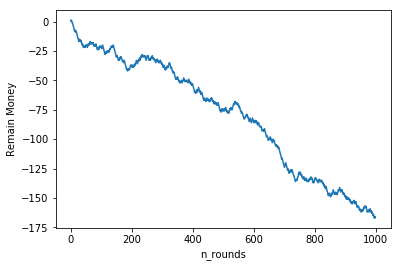

In [441]:
plot_history(remain_money_hist, rolling_window=1)

# Bet Agents

## Rule-based agents

## Deep Q Agent

In [442]:
# We need basically same agent for playing black jack. 
# Except a different learning and remenber method

def run_episode(env, agent):
    
    # Run the environment
    state = env.reset()  
    duration = 0
    done = False
    while not done:
        duration += 1
        # use network to choose action here
        action = agent.choose(state) # choose action based on current state
        next_state, reward, done, _ = env.step(action)
        # the even returns done=True when the take stops
        
        # see below but the agent includes a memory of the state, action, next_state, and reward
        # which can be helpful for training (replay)
        agent.remember(state, action, next_state, reward) # record what happened in memory
    
        # optimize the neural network model here (i.e., adjust learning weight)
        # you will implement this function
        agent.learn()
        
        # update the state
        state = next_state
    
    # return duration
    return duration

In [443]:
deep_bet_agenet = NetworkAgent(n_inputs=1, n_outputs=10, gamma=0.9)
bet_env = BlackjackBetEnv(blackjack_agent_class=NetworkAgent)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [444]:
n_episodes = 200
durations_history = []
for i in tqdm(range(n_episodes)):
    durations_history.append(run_episode(bet_env, deep_bet_agenet))

  0%|          | 0/200 [00:00<?, ?it/s]/Users/zhuorulin/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:168: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/Users/zhuorulin/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:142: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
100%|██████████| 200/200 [01:25<00:00,  2.33it/s]


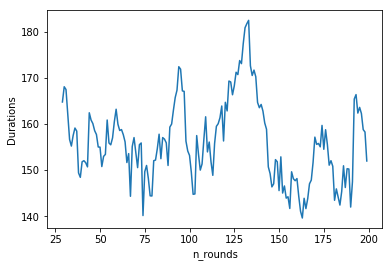

In [446]:
plot_history(durations_history,ylabel='Durations')

In [448]:
remain_money_hist = []
from tqdm import tqdm
state = test_env.reset()
for i in range(1000):
    action = deep_bet_agenet.choose(state)
    state, _, _, _ = test_env.step(action)
    remain_money_hist.append(state[0])

/Users/zhuorulin/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:168: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/Users/zhuorulin/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:142: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


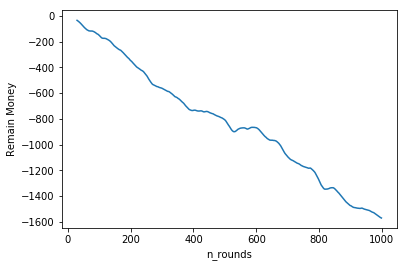

In [449]:
plot_history(remain_money_hist)